In [1]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical

# This code assumes you have 'KDDTrain+.txt' and 'KDDTest+.txt' in the same folder.

# 2. Load the Training and Testing Datasets
col_names = [f"feature_{i}" for i in range(41)] + ['label', 'difficulty']
print("Loading data...")
train_df = pd.read_csv(r"C:\Users\sande\Downloads\ids\nsl_kdd\KDDTrain+.txt", header=None, names=col_names)
test_df = pd.read_csv(r"C:\Users\sande\Downloads\ids\nsl_kdd\KDDTest+.txt", header=None, names=col_names)

# 3. Prepare the Data
train_df = train_df.drop('difficulty', axis=1)
test_df = test_df.drop('difficulty', axis=1)

# Separate features (X) and labels (y)
X_train = train_df.drop('label', axis=1)
y_train_str = train_df['label']
X_test = test_df.drop('label', axis=1)
y_test_str = test_df['label']

# --- Important Preprocessing Steps ---
print("Preprocessing data...")
# A. Convert Categorical Features to Numbers
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# B. Align columns
train_cols = X_train.columns
test_cols = X_test.columns
missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test[c] = 0
missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    X_train[c] = 0
X_test = X_test[X_train.columns]

# C. Scale Numerical Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# D. Encode Labels (from text to numbers)
# Combine all labels from both train and test sets to ensure the encoder learns every possible label.
all_labels = pd.concat([y_train_str, y_test_str])

le = LabelEncoder()
# Fit the encoder on ALL possible labels
le.fit(all_labels)

# Now, transform the train and test labels separately
y_train_encoded = le.transform(y_train_str)
y_test_encoded = le.transform(y_test_str)

# E. One-Hot Encode Labels for Keras
num_classes = len(le.classes_)
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

# F. CRUCIAL: Reshape data for LSTM
# LSTMs expect a 3D input shape: (samples, timesteps, features)
# We'll treat each sample as 1 timestep.
X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# 4. Build and Compile the LSTM Model
print("Building the LSTM model...")
model = Sequential()
# Add an LSTM layer with 64 units. input_shape is (timesteps, features)
model.add(LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
# Add the final output layer. 'softmax' is used for multi-class classification.
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 5. Train the Model
print("\nTraining the LSTM model...")
# Epochs are the number of times the model will see the entire training dataset.
# Batch size is the number of samples processed before the model is updated.
model.fit(X_train_reshaped, y_train_categorical, epochs=10, batch_size=64, validation_data=(X_test_reshaped, y_test_categorical))
print("Model training complete.")

# 6. Evaluate the Model's Performance
print("\n--- LSTM Model Evaluation ---")
# Predict probabilities on the test set
y_pred_proba = model.predict(X_test_reshaped)
# Convert probabilities to class labels
y_pred = np.argmax(y_pred_proba, axis=1)

print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_, zero_division=0))

Loading data...
Preprocessing data...
Building the LSTM model...


C:\Users\sande\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          47,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 40)                  │           2,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,472 (197.16 KB)

 Trainable params: 50,472 (197.16 KB)

 Non-trainable params: 0 (0.00 B)


Training the LSTM model...
Epoch 1/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9149 - loss: 0.6488 - val_accuracy: 0.6973 - val_loss: 2.3834
Epoch 2/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9907 - loss: 0.0364 - val_accuracy: 0.6973 - val_loss: 2.6428
Epoch 3/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9927 - loss: 0.0261 - val_accuracy: 0.7049 - val_loss: 2.7785
Epoch 4/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9937 - loss: 0.0212 - val_accuracy: 0.7027 - val_loss: 2.9235
Epoch 5/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9940 - loss: 0.0195 - val_accuracy: 0.7020 - val_loss: 3.0855
Epoch 6/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9947 - loss: 0.0181 - val_accuracy: 0.7103 - val_loss: 3.3057
Epoch 7/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9947 - loss: 0.0169 - val_accuracy: 0.7090 - val_loss: 3.4670
Epoch 8/10
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - ac

ValueError: Number of classes, 39, does not match size of target_names, 40. Try specifying the labels parameter

In [2]:
# We explicitly tell the report which labels to include.
# This ensures it generates a report for all 40 classes, solving the mismatch.
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_, labels=range(num_classes), zero_division=0))

                 precision    recall  f1-score   support

        apache2       0.00      0.00      0.00       737
           back       0.39      0.87      0.54       359
buffer_overflow       0.62      0.40      0.48        20
      ftp_write       1.00      0.33      0.50         3
   guess_passwd       1.00      0.01      0.02      1231
     httptunnel       0.00      0.00      0.00       133
           imap       0.08      1.00      0.15         1
        ipsweep       0.83      0.98      0.90       141
           land       1.00      1.00      1.00         7
     loadmodule       0.00      0.00      0.00         2
       mailbomb       0.00      0.00      0.00       293
          mscan       0.00      0.00      0.00       996
       multihop       0.00      0.00      0.00        18
          named       0.00      0.00      0.00        17
        neptune       0.90      0.99      0.94      4657
           nmap       0.43      0.99      0.60        73
         normal       0.69    


--- Rnn Model Performance ---
Overall Accuracy on the test set: 0.7131

Classification Report:
                 precision    recall  f1-score   support

        apache2       0.00      0.00      0.00       737
           back       0.39      0.87      0.54       359
buffer_overflow       0.62      0.40      0.48        20
      ftp_write       1.00      0.33      0.50         3
   guess_passwd       1.00      0.01      0.02      1231
     httptunnel       0.00      0.00      0.00       133
           imap       0.08      1.00      0.15         1
        ipsweep       0.83      0.98      0.90       141
           land       1.00      1.00      1.00         7
     loadmodule       0.00      0.00      0.00         2
       mailbomb       0.00      0.00      0.00       293
          mscan       0.00      0.00      0.00       996
       multihop       0.00      0.00      0.00        18
          named       0.00      0.00      0.00        17
        neptune       0.90      0.99      0.94  

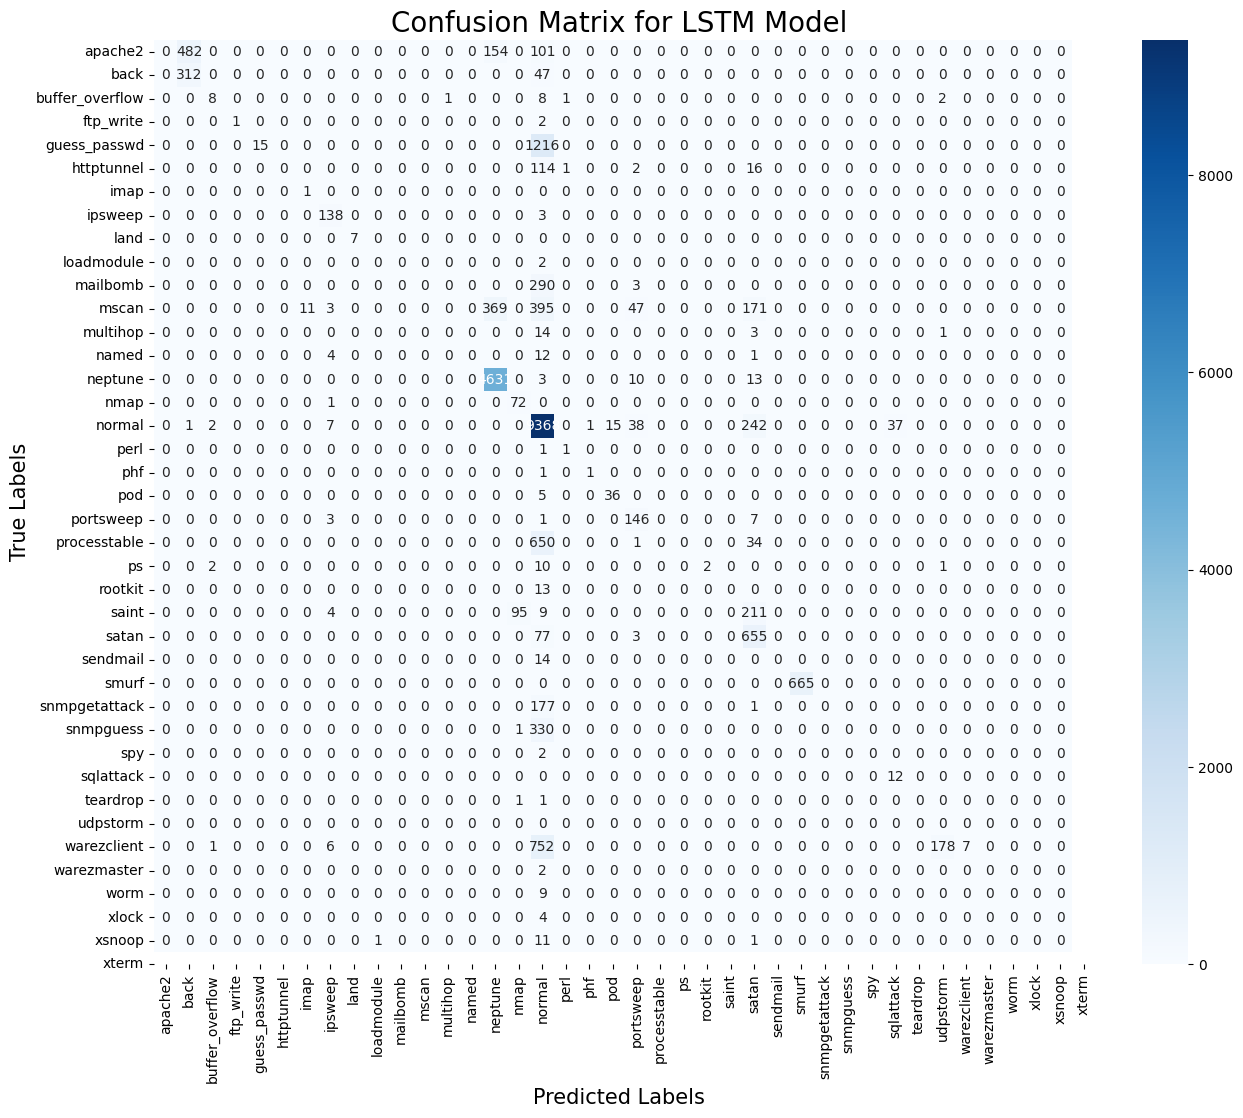

In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("\n--- Rnn Model Performance ---")
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Overall Accuracy on the test set: {accuracy:.4f}")

# 8. Print the Classification Report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_, labels=range(num_classes), zero_division=0))

# 9. Calculate and Visualize the Confusion Matrix
print("Generating Confusion Matrix...")
cm = confusion_matrix(y_test_encoded, y_pred)

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)

plt.title('Confusion Matrix for LSTM Model', fontsize=20)
plt.ylabel('True Labels', fontsize=15)
plt.xlabel('Predicted Labels', fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score
overall_precision = precision_score(y_test_encoded, y_pred, average='weighted', zero_division=0)

# This calculates the average recall, weighted by the number of samples in each class.
overall_recall = recall_score(y_test_encoded, y_pred, average='weighted', zero_division=0)

# This calculates the average F1-score, weighted by the number of samples in each class.
overall_f1 = f1_score(y_test_encoded, y_pred, average='weighted', zero_division=0)


# --- Print the results ---
print("\n--- Overall Performance Metrics ---")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1-Score: {overall_f1:.4f}")



--- Overall Performance Metrics ---
Overall Precision: 0.6425
Overall Recall: 0.7131
Overall F1-Score: 0.6161
